# Testing ensemble modeling calibration with synthetic data and custom models
This notebook is designed to test our ensemble modeling capability by generating synthetic data sampled from custom-made SIR-based models. 

### Load dependencies and set up the notebook environment

In [1]:
import os
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyro.nn import pyro_method
from pyro.infer import Predictive
from typing import Dict, Optional

from pyciemss.PetriNetODE.base import (
    ScaledBetaNoisePetriNetODESystem,
    MiraPetriNetODESystem,
    PetriNetODESystem,
    Time,
    State,
    Solution,
    get_name,
)
from pyciemss.utils import state_flux_constraint
from pyciemss.utils import get_tspan
from pyciemss.utils.distributions import ScaledBeta

from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.PetriNetODE.interfaces import sample as sample_petri
from pyciemss.PetriNetODE.interfaces import setup_model as setup_model_petri
from pyciemss.PetriNetODE.interfaces import intervene as intervene_petri
from pyciemss.PetriNetODE.interfaces import calibrate as calibrate_petri

from pyciemss.Ensemble.interfaces import setup_model as setup_model_ensemble
from pyciemss.Ensemble.interfaces import reset_model as reset_model_ensemble
from pyciemss.Ensemble.interfaces import intervene as intervene_ensemble
from pyciemss.Ensemble.interfaces import sample as sample_ensemble
from pyciemss.Ensemble.interfaces import calibrate as calibrate_ensemble
from pyciemss.Ensemble.interfaces import optimize as optimize_ensemble

### Plotting utilities

In [11]:
COLORS=['red','green','blue','black','gold','purple','orangered']

def plot_trajectories(sol, tspan, num_params, data=None):
    fig = plt.figure(facecolor='w', figsize=(6, 6))
    ax = fig.add_subplot(111, axisbelow=True) # setup graph
    d_keys = [list(x[1].keys())[0] for x in data] if data else [] # get affected variables
    torch_tspan = torch.as_tensor(tspan) # for use in multi-trajectory graph
    indices = torch.ones_like(tspan).bool()
    
    for i,var in enumerate(list(sol.keys())[num_params:]): # skip parameters
        
        if len(sol[list(sol.keys())[3]]) == 1: # single trajectory, draw line
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var)
        
        else: # fill between multiple trajectories
            I_low = torch.quantile(sol[var], 0.05, dim=0).detach().numpy()
            I_up  = torch.quantile(sol[var], 0.95, dim=0).detach().numpy()
            ax.fill_between(torch_tspan[indices], I_low[indices], I_up[indices],
                            alpha=0.2, color=COLORS[i], label=var)
        
        if var[:-4] in d_keys: # plot training points of this variable
            x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
            y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without '_sol' suffix
            ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
    
    ax.legend()

# Make some models

### Model 1: SIRHD
Model 1 state variables: Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}SI\\ 
\frac{dI}{dt} &= \frac{\beta}{N}SI - \gamma I\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I + \frac{1 - dh}{los}H\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\gamma$ recovery rate, $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [3]:
class SIRHD(PetriNetODESystem):
    # Susceptible (S), Infectious (I), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: infection rate
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "infectious_population": 1, "recovered_population": 2, 
                "hospitalized_population": 3, "deceased_population": 4}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, I, R, H, D = state
        dSdt = -self.beta * S * I / self.total_population
        dIdt = self.beta * S * I / self.total_population - self.gamma * I
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + ((1 - self.dh)/self.los) * H
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dIdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

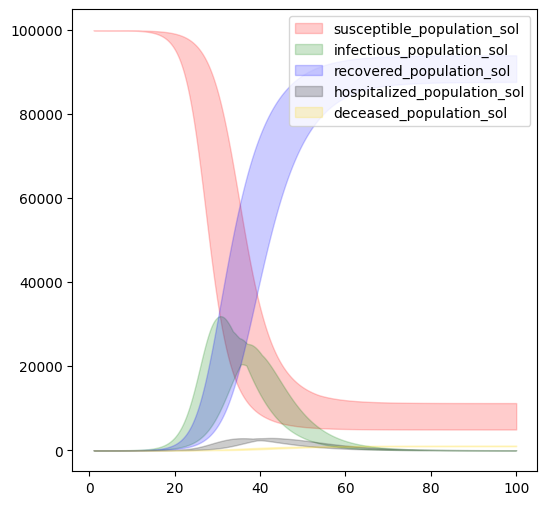

In [27]:
full_tspan = get_tspan(1, 100, 1000)
SIRHD_raw  = SIRHD(N=100000.0, beta=0.55, gamma=0.2, hosp=0.1, los=7, dh=0.1, dnh=0.001)
SIRHD_model = setup_model_petri(SIRHD_raw, start_time=0, start_state=dict(susceptible_population=99999.0,
                                                                  infectious_population=1.0,
                                                                  recovered_population=0.0, 
                                                                  hospitalized_population=0.0, 
                                                                  deceased_population=0.0))

model1_solution   = sample_petri(SIRHD_model, full_tspan, 10)

num_params = 6
plot_trajectories(model1_solution, full_tspan, num_params)
plt.show()

### Model 2: SEIARHD
Model 2 state variables: Susceptible (S), **Exposed** (E), **Symptomatic Infectious** (I), **Asymptomatic Infectious** (A), Recovered (R), Hospitalized (H), and Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}S(\delta I + A)\\ 
\frac{dE}{dt} &= \frac{\beta}{N}S(\delta I + A) - \frac{1}{\alpha} E\\
\frac{dI}{dt} &= \frac{pS}{\alpha}E - \gamma I\\
\frac{dA}{dt} &= \frac{1 - pS}{\alpha}E - \gamma A\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I + \gamma A + \frac{1 - dh}{los}H\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\delta$ difference in infectiousness symptomatic:asymptomatic (assume symptomatic individuals are more infectious than asymptomatic), $\alpha$ latency period (the average length of time between transmission and becoming infectious/showing symptoms), $pS$ percent of exposures which become symptomatic, $\gamma$ recovery rate (equal to 1/infectious_period), $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [5]:
class SEIARHD(PetriNetODESystem):
    # Susceptible (S), Exposed(E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            delta: float,
            alpha: float,
            pS: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: transmission rate
        :param delta: difference in infectiousness symptomatic/asymptomatic
        :param alpha: latency period
        :param pS: percent of exposures which become symptomatic
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.delta_prior = pyro.distributions.Uniform(max(0.9 * delta, 0.0), 1.1 * delta)
        self.alpha_prior = pyro.distributions.Uniform(max(0.9 * alpha, 0.0), 1.1 * alpha)
        self.pS_prior = pyro.distributions.Uniform(max(0.9 * pS, 0.0), 1.1 * pS)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "exposed_population": 1, "symptomatic_population": 2, 
                "asymptomatic_population": 3, "recovered_population": 4, 
                "hospitalized_population": 5, "deceased_population": 6}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, E, I, A, R, H, D = state
        dSdt = -self.beta * S * (self.delta * I + A) / self.total_population
        dEdt = self.beta * S * (self.delta * I + A) / self.total_population - (1/self.alpha) * E
        dIdt = (self.pS/self.alpha) * E - self.gamma * I
        dAdt = ((1 - self.pS)/self.alpha) * E - self.gamma * A
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + self.gamma * A + ((1 - self.dh)/self.los) * H
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dEdt, dIdt, dAdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'delta', pyro.sample('delta', self.delta_prior))
        setattr(self, 'alpha', pyro.sample('alpha', self.alpha_prior))
        setattr(self, 'pS', pyro.sample('pS', self.pS_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

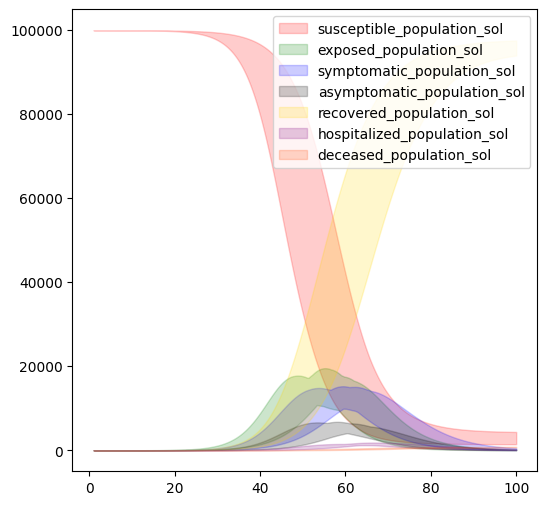

In [28]:
full_tspan = get_tspan(1, 100, 1000)
SEIARHD_raw  = SEIARHD(N=100000.0, beta=0.55, delta=1.5, alpha=4, pS=0.7, gamma=0.2, hosp=0.1, los=7, dh=0.1, dnh=0.001)
SEIARHD_model = setup_model_petri(SEIARHD_raw, start_time=0, start_state=dict(susceptible_population=99999.0,
                                                                  exposed_population=0.0,
                                                                  symptomatic_population=1.0,
                                                                  asymptomatic_population=0.0,
                                                                  recovered_population=0.0, 
                                                                  hospitalized_population=0.0, 
                                                                  deceased_population=0.0))

model2_solution   = sample_petri(SEIARHD_model, full_tspan, 10)

num_params = 9
plot_trajectories(model2_solution, full_tspan, num_params)
plt.show()

### Model 3: SEIARHDS
SEIARHDS is the same as Model 2, but with a return to *Susceptible* from *Recovered* \
Model 3 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), Deceased (D) \
\
Model equations: \
\
$\begin{align} \frac{dS}{dt} &= -\frac{\beta}{N}S(\delta I + A) + \frac{1}{\tau}R\\ 
\frac{dE}{dt} &= \frac{\beta}{N}S(\delta I + A) - \frac{1}{\alpha} E\\
\frac{dI}{dt} &= \frac{pS}{\alpha}E - \gamma I\\
\frac{dA}{dt} &= \frac{1 - pS}{\alpha}E - \gamma A\\
\frac{dR}{dt} &= \gamma(1 - hosp - dnh)I + \gamma A + \frac{1 - dh}{los}H - \frac{1}{\tau}R\\
\frac{dH}{dt} &= \gamma hosp I - \frac{1}{los}H\\
\frac{dD}{dt} &= \gamma dnh I + \frac{dh}{los}H
\end{align}$ \
\
Model parameters: $N$ total population, $\beta$ transmission rate, $\delta$ difference in infectiousness symptomatic:asymptomatic (assume symptomatic individuals are more infectious than asymptomatic), $\tau$ period of immunity from recovery, $\alpha$ latency period (the average length of time between transmission and becoming infectious/showing symptoms), $pS$ percent of exposures which become symptomatic, $\gamma$ recovery rate (equal to 1/infectious_period), $hosp$ hospitalization rate of infectious individuals, $los$ average length of hospital stay, $dh$ death rate of hospitalized individuals, $dnh$ death rate of infectious individuals (never hospitalized)

In [19]:
class SEIARHDS(PetriNetODESystem):
    # Susceptible (S), Exposed(E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), Deceased (D)
    def __init__(
            self,
            N: int,
            beta: float,
            delta: float,
            tau: float,
            alpha: float,
            pS: float,
            gamma: float,
            hosp: float,
            los: float,
            dh: float,
            dnh: float,
            pseudocount: float = 1.0,
            ) -> None:
        """initialize parameters
        :param N: total population
        :param beta: transmission rate
        :param delta: difference in infectiousness symptomatic/asymptomatic
        :param tau: immunity period
        :param alpha: latency period
        :param pS: percent of exposures which become symptomatic
        :param gamma: recovery rate
        :param hosp: hospitalization rate of infectious individuals
        :param los: average length (days) of hospital stay
        :param dh: death rate of hospitalized individuals
        :param dnh: death rate of infectious individuals (never hospitalized)
        """
        super().__init__()
        self.total_population = N
        self.beta_prior =  pyro.distributions.Uniform(max(0.9 * beta, 0.0), 1.1 * beta)
        self.delta_prior = pyro.distributions.Uniform(max(0.9 * delta, 0.0), 1.1 * delta)
        self.tau_prior = pyro.distributions.Uniform(max(0.9 * tau, 0.0), 1.1 * tau)
        self.alpha_prior = pyro.distributions.Uniform(max(0.9 * alpha, 0.0), 1.1 * alpha)
        self.pS_prior = pyro.distributions.Uniform(max(0.9 * pS, 0.0), 1.1 * pS)
        self.gamma_prior = pyro.distributions.Uniform(max(0.9 * gamma, 0.0), 1.1 * gamma)
        self.hosp_prior = pyro.distributions.Uniform(max(0.9 * hosp, 0.0), 1.1 * hosp)
        self.los_prior = pyro.distributions.Uniform(max(0.9 * los, 0.0), 1.1 * los)
        self.dh_prior = pyro.distributions.Uniform(max(0.9 * dh, 0.0), 1.1 * dh)
        self.dnh_prior = pyro.distributions.Uniform(max(0.9 * dnh, 0.0), 1.1 * dnh)
        self.pseudocount = pseudocount


    def create_var_order(self) -> dict[str, int]:
        """create the variable order for the state vector"""
        return {"susceptible_population": 0, "exposed_population": 1, "symptomatic_population": 2, 
                "asymptomatic_population": 3, "recovered_population": 4, 
                "hospitalized_population": 5, "deceased_population": 6}

    @pyro.nn.pyro_method
    def deriv(self, t: Time, state: State) -> State:
        """compute the state derivative at time t
        :param t: time
        :param state: state vector
        :return: state derivative vector
        """
        assert torch.isclose(sum(state),self.total_population),f"The sum of state variables {state} is not scaled to the total population {self.total_population}."
        S, E, I, A, R, H, D = state
        dSdt = -self.beta * S * (self.delta * I + A) / self.total_population + (1/self.tau) * R
        dEdt = self.beta * S * (self.delta * I + A) / self.total_population - (1/self.alpha) * E
        dIdt = (self.pS/self.alpha) * E - self.gamma * I
        dAdt = ((1 - self.pS)/self.alpha) * E - self.gamma * A
        dRdt = self.gamma * (1 - self.hosp - self.dnh) * I + self.gamma * A + ((1 - self.dh)/self.los) * H - (1/self.tau) * R
        dHdt = self.gamma * self.hosp * I - (1/self.los) * H
        dDdt = self.gamma * self.dnh * I + (self.dh/self.los) * H
        return dSdt, dEdt, dIdt, dAdt, dRdt, dHdt, dDdt

    @pyro.nn.pyro_method
    def param_prior(self) -> None:
        """define the prior distributions for the parameters"""
        setattr(self, 'beta', pyro.sample('beta', self.beta_prior))
        setattr(self, 'delta', pyro.sample('delta', self.delta_prior))
        setattr(self, 'tau', pyro.sample('tau', self.tau_prior))
        setattr(self, 'alpha', pyro.sample('alpha', self.alpha_prior))
        setattr(self, 'pS', pyro.sample('pS', self.pS_prior))
        setattr(self, 'gamma', pyro.sample('gamma', self.gamma_prior))
        setattr(self, 'hosp', pyro.sample('hosp', self.hosp_prior))
        setattr(self, 'los', pyro.sample('los', self.los_prior))
        setattr(self, 'dh', pyro.sample('dh', self.dh_prior))
        setattr(self, 'dnh', pyro.sample('dnh', self.dnh_prior))

    @pyro.nn.pyro_method
    def observation_model(self, solution: Solution, var_name: str) -> None:
        """define the observation model for the given variable
        :param solution: solution of the ODE system
        :param var_name: variable name
        """
        mean = solution[var_name]
        pseudocount = self.pseudocount
        pyro.sample(var_name, ScaledBeta(mean, self.total_population, pseudocount).to_event(1))

    def static_parameter_intervention(self, parameter: str, value: torch.Tensor) -> None:
        """set a static parameter intervention
        :param parameter: parameter name
        :param value: parameter value
        """
        setattr(self, parameter, value)

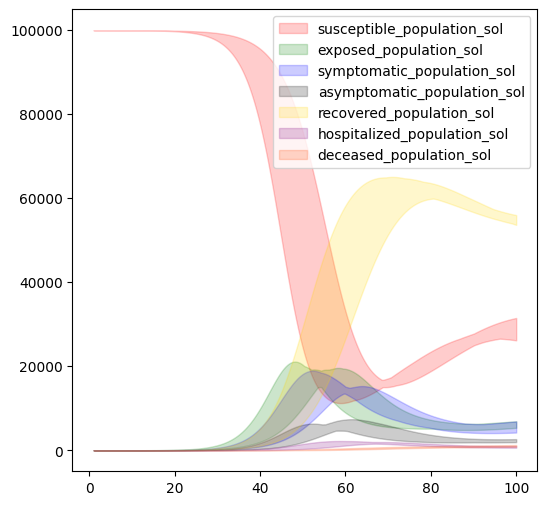

In [29]:
full_tspan = get_tspan(1, 100, 1000)
SEIARHDS_raw  = SEIARHDS(N=100000.0, beta=0.55, delta=1.5, tau=30, alpha=4, pS=0.7, gamma=0.2, hosp=0.1, los=7, dh=0.1, dnh=0.001)
SEIARHDS_model = setup_model_petri(SEIARHDS_raw, start_time=0, start_state=dict(susceptible_population=99999.0,
                                                                  exposed_population=0.0,
                                                                  symptomatic_population=1.0,
                                                                  asymptomatic_population=0.0,
                                                                  recovered_population=0.0, 
                                                                  hospitalized_population=0.0, 
                                                                  deceased_population=0.0))

model3_solution   = sample_petri(SEIARHDS_model, full_tspan, 10)

num_params = 10
plot_trajectories(model3_solution, full_tspan, num_params)
plt.show()

# Form synthetic dataset from model output

In [31]:
# Define solution mapping for each model
def solution_mapping1(model1_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model1_solution["infectious_population"]
    mapped_dict["Hospitalizations"] = model1_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model1_solution["deceased_population"]
    return mapped_dict

def solution_mapping2(model2_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model2_solution["symptomatic_population"] + model2_solution["asymptomatic_population"]
    mapped_dict["Hospitalizations"] = model2_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model2_solution["deceased_population"]
    return mapped_dict

def solution_mapping3(model3_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model3_solution["symptomatic_population"] + model3_solution["asymptomatic_population"]
    mapped_dict["Hospitalizations"] = model3_solution["hospitalized_population"]
    mapped_dict["Deaths"] = model3_solution["deceased_population"]
    return mapped_dict

In [109]:
# Run one sample of each model to use in synthetic dataset
model1_sample   = sample_petri(SIRHD_model, full_tspan, 1)
model2_sample   = sample_petri(SEIARHD_model, full_tspan, 1)
model3_sample   = sample_petri(SEIARHDS_model, full_tspan, 1)
print(model1_sample['beta'])
print(model2_sample['beta'])
print(model3_sample['beta'])

tensor([0.5671])
tensor([0.5976])
tensor([0.5764])


In [39]:
# Create dictionary to hold synthetic data
synth_data = {}

# Grab Model 1 sample and map to solution
state_variable_names = ["susceptible_population_sol", "infectious_population_sol", "recovered_population_sol", 
                       "hospitalized_population_sol", "deceased_population_sol"]
state_var_sol_dict = {}
for n in state_variable_names:
    state_var_sol_dict[n[0:-4]] = model1_sample[n]

synth_data['model1'] = solution_mapping1(state_var_sol_dict)
print(synth_data['model1'].keys())

# Grab Model 2 sample and map to solution
state_variable_names = ["susceptible_population_sol", "exposed_population_sol", "symptomatic_population_sol", 
                        "asymptomatic_population_sol", "recovered_population_sol", "hospitalized_population_sol", 
                        "deceased_population_sol"]
state_var_sol_dict = {}
for n in state_variable_names:
    state_var_sol_dict[n[0:-4]] = model2_sample[n]

synth_data['model2'] = solution_mapping2(state_var_sol_dict)
print(synth_data['model2'].keys())

# Grab Model 3 sample and map to solution
state_var_sol_dict = {}
for n in state_variable_names:
    state_var_sol_dict[n[0:-4]] = model3_sample[n]

synth_data['model3'] = solution_mapping3(state_var_sol_dict)
print(synth_data['model3'].keys())

dict_keys(['Cases', 'Hospitalizations', 'Deaths'])
dict_keys(['Cases', 'Hospitalizations', 'Deaths'])
dict_keys(['Cases', 'Hospitalizations', 'Deaths'])


In [80]:
# Assign weights for each model
generating_weights = [0.5, 0.3, 0.2]
model_weights = dict(zip(synth_data.keys(), generating_weights))

# Create a DataFrame containing the weighted sum of the different model solutions for each variable
model_names = synth_data.keys()
var_names = synth_data['model1'].keys()
new_synth_data_dict = {}
for vn in var_names:
    this_var = 0*synth_data['model1'][vn][0]
    for mn in synth_data.keys():
        this_var = this_var + model_weights[mn]*synth_data[mn][vn][0]
    new_synth_data_dict[vn] = this_var.numpy()
synth_data_df = pd.DataFrame.from_dict(new_synth_data_dict)

# Keep only integer time values so there's one data point per day
N_t = 100
t_points = get_tspan(1, N_t, 10*(N_t - 1) + 1)
keep_idx = [i for i,t in enumerate(t_points) if int(t) == t] 
synth_data_df = synth_data_df.iloc[keep_idx]

# Add a date column
from datetime import date, timedelta, datetime

start_date = date(2021, 12, 1)
date_col = [start_date]*len(synth_data_df)
for i in range(len(synth_data_df)):
    date_col[i] = f"{start_date + timedelta(days = i)}"
    
synth_data_df["Date"] = date_col
synth_data_df = synth_data_df.iloc[:, [3, 0, 1, 2]]

# Reset DataFrame index
synth_data_df = synth_data_df.reset_index(drop = True)
synth_data_df

,Date,Cases,Hospitalizations,Deaths
0,2021-12-01,1.148072,0.021550,0.000364
1,2021-12-02,1.445106,0.044513,0.001072
2,2021-12-03,1.896184,0.071668,0.002196
3,2021-12-04,2.531795,0.105761,0.003845
4,2021-12-05,3.406451,0.150121,0.006180
...,...,...,...,...
95,2022-03-06,1864.306152,295.699890,1030.708740
96,2022-03-07,1853.739502,287.199280,1035.079590
97,2022-03-08,1847.661743,279.767761,1039.343262
98,2022-03-09,1845.407227,273.323212,1043.513794


In [62]:
# Make a separate DataFrame to hold output from each model independently
model1_df = pd.DataFrame.from_dict({k: synth_data['model1'][k][0] for k in synth_data['model1']})
model2_df = pd.DataFrame.from_dict({k: synth_data['model2'][k][0] for k in synth_data['model2']})
model3_df = pd.DataFrame.from_dict({k: synth_data['model3'][k][0] for k in synth_data['model3']})

## Plot synthetic data

In [63]:
def plot_observations(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data, color, alpha=alpha, lw=lw, marker=marker, label=label)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    return ax

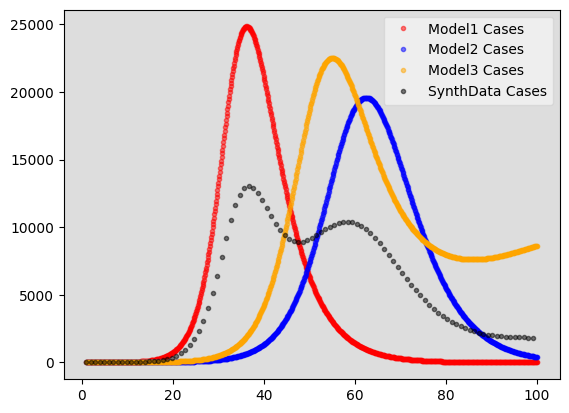

In [65]:
ax = plot_observations(model1_df['Cases'], full_tspan, color="red", label="Model1 Cases")
ax = plot_observations(model2_df['Cases'], full_tspan, ax=ax, color="blue", label="Model2 Cases")
ax = plot_observations(model3_df['Cases'], full_tspan, ax=ax, color="orange", label="Model3 Cases")
ax = plot_observations(synth_data_df['Cases'], full_tspan[keep_idx], ax=ax, color="black", label="SynthData Cases")

In [113]:
# Add Gaussian noise to the data (10%)
# TODO: np.random.seed(7)
import copy
synth_data_noise_df = copy.deepcopy(synth_data_df)
col_names = ["Cases", "Hospitalizations", "Deaths"]
row_num = len(synth_data_noise_df)
col_num = len(col_names)
synth_data_noise_df[col_names] = abs(synth_data_noise_df[col_names] + np.multiply(0.1 * synth_data_noise_df[col_names], np.random.randn(row_num, col_num)))
display(synth_data_noise_df)
display(synth_data_df)

,Date,Cases,Hospitalizations,Deaths
0,2021-12-01,1.091029,0.021582,0.000420
1,2021-12-02,1.437274,0.048222,0.001070
2,2021-12-03,1.871347,0.068363,0.002100
3,2021-12-04,2.303086,0.115158,0.003905
4,2021-12-05,3.112991,0.139970,0.006660
...,...,...,...,...
95,2022-03-06,2123.364699,308.750344,954.326640
96,2022-03-07,1866.642884,316.570857,970.015770
97,2022-03-08,1787.204760,295.267544,1062.223009
98,2022-03-09,1731.462356,254.127914,1097.651848


,Date,Cases,Hospitalizations,Deaths
0,2021-12-01,1.148072,0.021550,0.000364
1,2021-12-02,1.445106,0.044513,0.001072
2,2021-12-03,1.896184,0.071668,0.002196
3,2021-12-04,2.531795,0.105761,0.003845
4,2021-12-05,3.406451,0.150121,0.006180
...,...,...,...,...
95,2022-03-06,1864.306152,295.699890,1030.708740
96,2022-03-07,1853.739502,287.199280,1035.079590
97,2022-03-08,1847.661743,279.767761,1039.343262
98,2022-03-09,1845.407227,273.323212,1043.513794


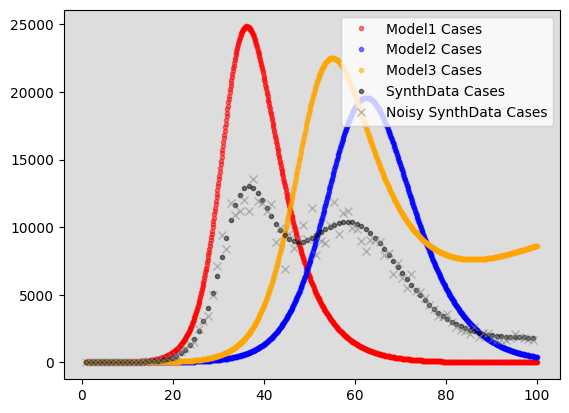

In [120]:
ax = plot_observations(model1_df['Cases'], full_tspan, color="red", label="Model1 Cases")
ax = plot_observations(model2_df['Cases'], full_tspan, ax=ax, color="blue", label="Model2 Cases")
ax = plot_observations(model3_df['Cases'], full_tspan, ax=ax, color="orange", label="Model3 Cases")
ax = plot_observations(synth_data_df['Cases'], full_tspan[keep_idx], ax=ax, color="black", label="SynthData Cases")
ax = plot_observations(synth_data_noise_df['Cases'], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy SynthData Cases")
ax.legend(loc="upper right")

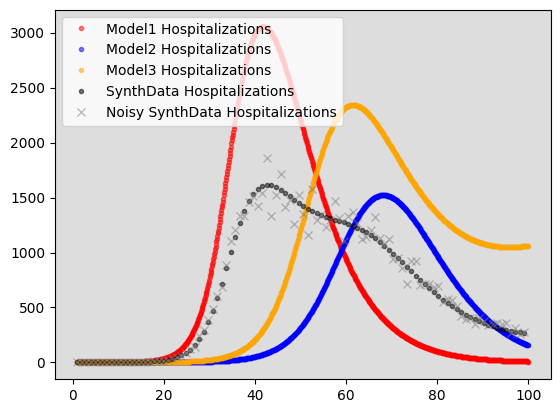

In [112]:
var_name = "Hospitalizations"
ax = plot_observations(model1_df[var_name], full_tspan, color="red", label="Model1 " + var_name)
ax = plot_observations(model2_df[var_name], full_tspan, ax=ax, color="blue", label="Model2 " + var_name)
ax = plot_observations(model3_df[var_name], full_tspan, ax=ax, color="orange", label="Model3 " + var_name)
ax = plot_observations(synth_data_df[var_name], full_tspan[keep_idx], ax=ax, color="black", label="SynthData " + var_name)
ax = plot_observations(synth_data_noise_df[var_name], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy SynthData " + var_name)
ax.legend(loc="upper left")

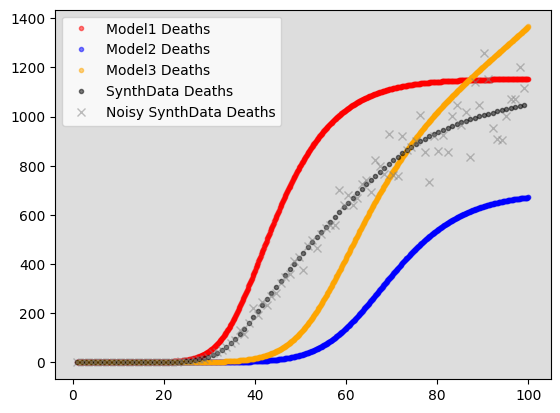

In [111]:
var_name = "Deaths"
ax = plot_observations(model1_df[var_name], full_tspan, color="red", label="Model1 " + var_name)
ax = plot_observations(model2_df[var_name], full_tspan, ax=ax, color="blue", label="Model2 " + var_name)
ax = plot_observations(model3_df[var_name], full_tspan, ax=ax, color="orange", label="Model3 " + var_name)
ax = plot_observations(synth_data_df[var_name], full_tspan[keep_idx], ax=ax, color="black", label="SynthData " + var_name)
ax = plot_observations(synth_data_noise_df[var_name], full_tspan[keep_idx], ax=ax, color="grey", marker="x", label="Noisy SynthData " + var_name)
ax.legend(loc="upper left")

# Test (ensemble of one) model at a time

In [110]:
synth_data_noise_df = copy.deepcopy(synth_data_df)
col_names = ["Cases", "Hospitalizations", "Deaths"]
row_num = len(synth_data_noise_df)
col_num = len(col_names)
synth_data_noise_df[col_names] = synth_data_noise_df[col_names] + np.multiply(0.1 * synth_data_noise_df[col_names], np.random.randn(row_num, col_num))
display(synth_data_noise_df)
display(synth_data_df)

,Cases,Hospitalizations,Deaths
0,1.392811,0.025049,0.000400
1,1.439300,0.027855,0.000464
2,1.487341,0.030728,0.000534
3,1.536986,0.033673,0.000608
4,1.588288,0.036690,0.000688
...,...,...,...
995,3.046647,9.220404,1152.831787
996,3.000000,9.106436,1152.844971
997,2.954069,8.993855,1152.858276
998,2.908840,8.882649,1152.871582


# Test ensemble of all three models

## Create ensemble model

### Next steps
1. create noisy data from each model independently
2. write a function that takes one model and some data as input, creates and calibrates an ensemble of that one model, plots the results as well as the calibration error in weights/parameters.
4. run these functions on various combinations of model generated data and models in the ensemble

Other TODO:
1. write a function that takes in a model or a few models and some weights, and generates a synthetic data set (with and without noise)
2. figure out how to seed random numbers